# QML for Conspicuity Detection

The goal of this project is to design and implement a Quantum Machine Learning (QML) model to learn and classify Aluminum weld defects on the dataset produced by Bacioiua et al (see Ref [1].) I.e., this is a multi-class image classification task. 

The dataset consists of many high-resolution HDR images of Aluminum welding processes subject to different conditions such as to produce defective or non-defective welds. The defective welds are further categorized into 5 different defects as shown below: 

<div style="text-align:center">
    <img src="static/welds.png" alt="Alt Text" style="width:500px;"/>
    <p>Dataset Classes <a href="https://doi.org/10.1016/j.jmapro.2019.07.020">(Ref [1])</a>.</p>
</div>


The authors in Ref[1] used classical Convolutional Neural Networks (CNNs) for this task. Our approach is to implement a Quanvolutional Neural Network (QNN) as first introduced in Ref[2].  In stead of a matrix filter, a quantum circuit is going to do the convulotion by:

1. encoding a small region of the input image (2 $\times$ 2 square) into the quantum state of 4-qubit register.
2. evolving the system with a Unitary $U$.
3. measuring the system and storing each outcome into a different feature map.
4. iterating this procedure over all 2 $\times$ 2 squares, so the full imput image is scanned. There sulting feature maps of the input image can be structured as a multi-channel image.

The below figure summarizes this procedure. Once the feature maps have been generated by our quantum layer, the results are flattened and fed into a classical fully-connected Neural Network for the final classification step. The main advantge of having a quantum circuit do the convolution is that it could implement very complex kernels whose classical counterpart could be computationally intractble.

<div style="text-align:center">
    <img src="static/QNN.png" alt="Alt Text" style="width:800px; height:500px;"/>
    <p>Quantum Convolution <a href="https://pennylane.ai/qml/demos/tutorial_quanvolution/">(source)</a>.</p>
</div>

To evaluate our hybrid quantum model, we compare it with a purely classcal one of the same architecutre, with the quanvolutional layer replaced by a typical 2D Convolutional layer of the same size.


In [170]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import json
import os
from PIL import Image
import random

In [171]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers

SAVE_PATH = "quanvolved_imgs/"  # Data saving folder
PREPROCESS = False              # If False, skip quantum processing and load data from SAVE_PATH

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

### Data Preprocessing

In [172]:
train_json = 'al5083/train/train.json'

with open(train_json, 'r') as json_file:
    train_data_json = json.load(json_file)

In [173]:
all_data = []
label_count = [0, 0, 0, 0, 0, 0]

In [174]:
image_size = (40, 40)

def load_data(path):
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if(os.path.isdir(folder_path)):
            for img_name in os.listdir(folder_path):
                
                img_path = os.path.join(folder_path, img_name)
                key_name = folder + '/' + img_name
                label = train_data_json[key_name]
                
                if(label_count[label] > 166):
                    continue
                    
                label_count[label] += 1
                image = Image.open(img_path).resize(image_size)
                image = np.array(image)
                all_data.append((image, label))
                
                if(len(all_data)%100==0):
                    print(f"Total images loaded : {len(all_data)}, Label count : {label_count}", end = '\r')

In [175]:
load_data('al5083/train')

In [176]:
for i in range(3):
    random.shuffle(all_data)

In [177]:
all_images = []
all_lables = []

for data in all_data:
    all_images.append(data[0])
    all_lables.append(data[1])

all_images = np.asarray(all_images)
all_lables = np.asarray(all_lables)

In [198]:
# Split dataset into train and test subsets
train_images, test_images, train_lables, test_lables = train_test_split(
    all_images, all_lables, test_size=0.15, random_state=42)

In [179]:
# Add extra dimension for convolution channels and normalize
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False) / 255
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False) / 255

In [180]:
np.shape(train_images), np.shape(test_images), np.shape(train_lables), np.shape(test_lables)

((851, 40, 40, 1), (151, 40, 40, 1), (851,), (151,))

### Quantum Convolution

In [183]:
dev = qml.device("lightning.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [184]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((20, 20, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 40, 2):
        for k in range(0, 40, 2):
            # Process a squared 2x2 region of the image with out quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [185]:
# If feature maps haven't been generated:
if PREPROCESS == True:
    
    # Apply quanvolution and save results 
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx, 850), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx , 150), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

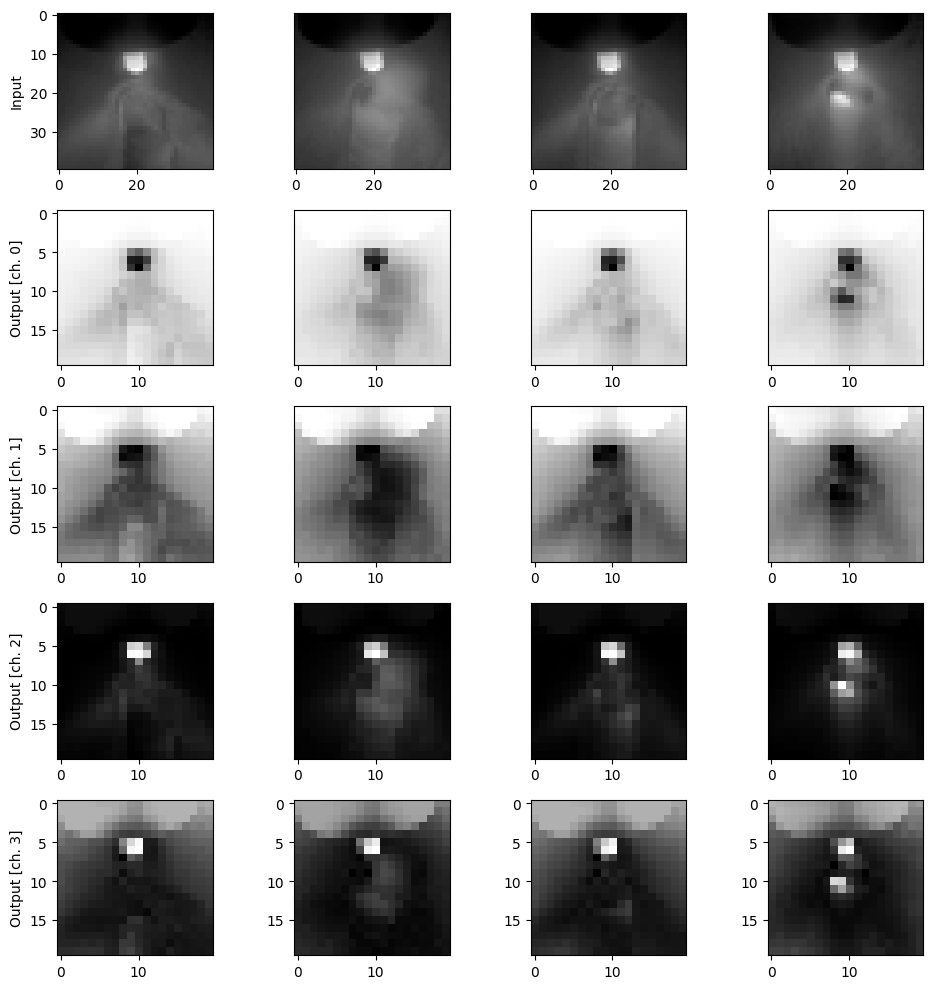

In [187]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))

# Viewing channel outputs
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")
    
plt.tight_layout()
plt.show()

### Model Training

In [188]:
# Quantum Convolutional Model
def QuavolutionalModel():
    model = keras.models.Sequential([
        keras.layers.Flatten(), # Flatten Layer
        keras.layers.Dense(60, activation="relu"),  # Fully connected layer
        keras.layers.Dense(6, activation="softmax") # Fully connected layer
    ])

    model.compile(
        optimizer='adagrad', # Adaptive Moment Estimation algorithm
        loss="sparse_categorical_crossentropy", # Loss function
        metrics=["accuracy"], # Measures the fraction of correctly predicted instances
    )
    
    return model

In [189]:
q_model = QuavolutionalModel()

q_history = q_model.fit(
    q_train_images,
    train_lables,
    validation_data=(q_test_images, test_lables),
    batch_size=10,
    epochs=n_epochs,
    verbose=1,
)

q_model.summary()

Epoch 1/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4110 - loss: 1.6305 - val_accuracy: 0.5099 - val_loss: 1.3859
Epoch 2/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7725 - loss: 1.2618 - val_accuracy: 0.6887 - val_loss: 1.1350
Epoch 3/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8928 - loss: 1.0353 - val_accuracy: 0.8609 - val_loss: 0.9625
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9208 - loss: 0.8836 - val_accuracy: 0.9007 - val_loss: 0.8423
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9337 - loss: 0.7742 - val_accuracy: 0.9205 - val_loss: 0.7422
Epoch 6/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9394 - loss: 0.6879 - val_accuracy: 0.9205 - val_loss: 0.6697
Epoch 7/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9455 - loss: 0.6211 - val_accuracy: 0.9272 - val_loss: 0.6082
Epoch 8/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9495 - loss: 0.5660 - val_accuracy: 0.9272 - val_loss:

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_22 (Flatten)            │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 60)             │        96,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 6)              │           366 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 192,854 (753.34 KB)

 Trainable params: 96,426 (376.66 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 96,428 (376.68 KB)

In [190]:
# Classical Convolutional Model
def ClassicalModel():
    model = keras.models.Sequential([
        keras.layers.Conv2D(4, (2, 2), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(60, activation="relu"),
        keras.layers.Dense(6, activation='softmax')
    ])

    model.compile(
        optimizer='adagrad', # Optimizer with parameter-specific learning rates
        loss="sparse_categorical_crossentropy", # Loss function
        metrics=["accuracy"], # Measures the fraction of correctly predicted instances
    )
    
    return model

In [194]:
c_model = ClassicalModel()

c_history = c_model.fit(
    train_images,
    train_lables,
    validation_data=(test_images, test_lables),
    batch_size=10,
    epochs=n_epochs,
    verbose=1,
)

c_model.summary()

Epoch 1/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1666 - loss: 1.7877 - val_accuracy: 0.1589 - val_loss: 1.7852
Epoch 2/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1666 - loss: 1.7826 - val_accuracy: 0.1589 - val_loss: 1.7815
Epoch 3/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1666 - loss: 1.7792 - val_accuracy: 0.1656 - val_loss: 1.7786
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1746 - loss: 1.7763 - val_accuracy: 0.1854 - val_loss: 1.7756
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1849 - loss: 1.7733 - val_accuracy: 0.2119 - val_loss: 1.7725
Epoch 6/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2299 - loss: 1.7701 - val_accuracy: 0.2715 - val_loss: 1.7693
Epoch 7/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2659 - loss: 1.7668 - val_accuracy: 0.3377 - val_loss: 1.7659
Epoch 8/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3411 - loss: 1.7634 - val_accuracy: 0.3642 - val_loss:

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 39, 39, 4)      │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 19, 19, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 1444)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 60)             │        86,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 6)              │           366 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 174,174 (680.37 KB)

 Trainable params: 87,086 (340.18 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 87,088 (340.19 KB)

## Results

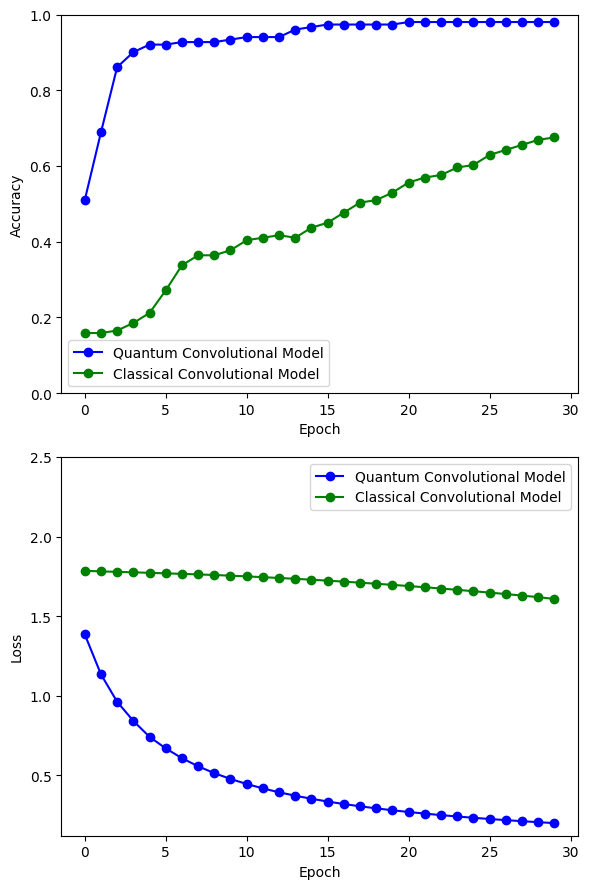

In [199]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="Quantum Convolutional Model")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Classical Convolutional Model")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="Quantum Convolutional Model")
ax2.plot(c_history.history["val_loss"], "-og", label="Classical Convolutional Model")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

We see that the quantum model far outperforms the purely classical one in terms of convergence time

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


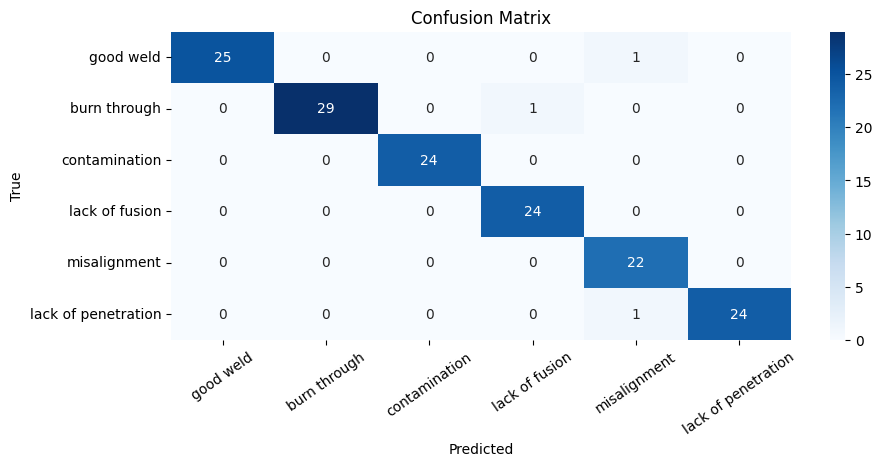

In [196]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

classes = ['good weld', 'burn through', 'contamination', 'lack of fusion', 'misalignment' , 'lack of penetration']

# Make predictions
y_pred = q_model.predict(q_test_images)

y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(test_lables, y_pred_classes)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(10, 4))

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=classes,  # replace with your class names
            yticklabels=classes)  # replace with your class names
plt.xticks(rotation=35)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### References

[1] Bacioiu, D., Melton, G., Papaelias, M., & Shaw, R. (2019). Automated defect classification of Aluminium 5083 TIG welding using HDR camera and neural networks. Journal of manufacturing processes, 45, 603-613. DOI: https://doi.org/10.1016/j.jmapro.2019.07.020

[2] Maxwell Henderson, Samriddhi Shakya, Shashindra Pradhan, Tristan Cook. “Quanvolutional Neural Networks: Powering Image Recognition with Quantum Circuits.” arXiv:1904.04767, 2019.